In [18]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [19]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [20]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [21]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

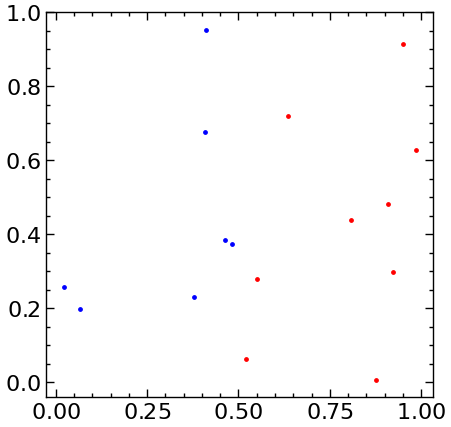

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [23]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [24]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [25]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.5497, 0.9854],
        [0.5497, 0.4620],
        [0.5497, 0.5207],
        [0.5497, 0.9231],
        [0.5497, 0.0213],
        [0.5497, 0.0666],
        [0.5497, 0.9084],
        [0.5497, 0.9509],
        [0.5497, 0.6367],
        [0.5497, 0.4103],
        [0.5497, 0.8770],
        [0.5497, 0.4815],
        [0.5497, 0.8089],
        [0.5497, 0.3789],
        [0.5497, 0.4075],
        [0.9854, 0.4620],
        [0.9854, 0.5207],
        [0.9854, 0.9231],
        [0.9854, 0.0213],
        [0.9854, 0.0666],
        [0.9854, 0.9084],
        [0.9854, 0.9509],
        [0.9854, 0.6367],
        [0.9854, 0.4103],
        [0.9854, 0.8770],
        [0.9854, 0.4815],
        [0.9854, 0.8089],
        [0.9854, 0.3789],
        [0.9854, 0.4075],
        [0.4620, 0.5207],
        [0.4620, 0.9231],
        [0.4620, 0.0213],
        [0.4620, 0.0666],
        [0.4620, 0.9084],
        [0.4620, 0.9509],
        [0.4620, 0.6367],
        [0.4620, 0.4103],
        [0.4620, 0.8770],
        [0.4

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [26]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.4357, -0.0877, -0.0290,  0.3734, -0.5285, -0.4831,  0.3587,  0.4012,
         0.0870, -0.1395,  0.3273, -0.0682,  0.2592, -0.1708, -0.1422, -0.5234,
        -0.4647, -0.0623, -0.9641, -0.9188, -0.0770, -0.0345, -0.3487, -0.5751,
        -0.1084, -0.5039, -0.1765, -0.6065, -0.5779,  0.0587,  0.4611, -0.4407,
        -0.3954,  0.4464,  0.4889,  0.1747, -0.0517,  0.4150,  0.0195,  0.3469,
        -0.0831, -0.0545,  0.4024, -0.4994, -0.4540,  0.3877,  0.4302,  0.1160,
        -0.1104,  0.3564, -0.0391,  0.2882, -0.1418, -0.1131, -0.9018, -0.8565,
        -0.0147,  0.0278, -0.2864, -0.5128, -0.0461, -0.4415, -0.1142, -0.5442,
        -0.5156,  0.0454,  0.8871,  0.9296,  0.6155,  0.3890,  0.8558,  0.4603,
         0.7876,  0.3576,  0.3863,  0.8418,  0.8843,  0.5701,  0.3436,  0.8104,
         0.4149,  0.7423,  0.3123,  0.3409,  0.0425, -0.2717, -0.4981, -0.0314,
        -0.4269, -0.0995, -0.5295, -0.5009, -0.3142, -0.5406, -0.0738, -0.4693,
        -0.1420, -0.5720, -0.5434, -0.22

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [27]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.5580, 0.1371, 0.2198, 0.3738, 0.5289, 0.4902, 0.4117, 0.7505, 0.4475,
        0.6873, 0.4262, 0.1163, 0.3041, 0.1775, 0.4199, 0.5772, 0.7328, 0.3363,
        1.0327, 1.0152, 0.1657, 0.2877, 0.3602, 0.6603, 0.6310, 0.5645, 0.2591,
        0.7249, 0.5797, 0.3286, 0.4693, 0.4586, 0.4381, 0.4567, 0.7202, 0.3765,
        0.5699, 0.5616, 0.0225, 0.3510, 0.1748, 0.2948, 0.4665, 0.5367, 0.4736,
        0.5715, 0.9546, 0.6670, 0.8977, 0.3606, 0.3145, 0.4745, 0.2210, 0.6234,
        0.9027, 0.8624, 0.1844, 0.6168, 0.5090, 0.8317, 0.2947, 0.4480, 0.1813,
        0.5482, 0.6387, 0.0767, 0.9149, 1.1376, 0.7686, 0.7960, 0.8920, 0.4746,
        0.8080, 0.3587, 0.5681, 0.8888, 1.1388, 0.7731, 0.8307, 0.8323, 0.4513,
        0.7808, 0.3142, 0.5874, 0.4344, 0.3605, 0.6855, 0.4760, 0.4403, 0.1084,
        0.5857, 0.5368, 0.3699, 0.5420, 0.9102, 0.7155, 0.4961, 0.8906, 0.5937,
        0.3257, 0.7513, 0.3781, 0.3287, 0.5513, 0.2334, 1.0548, 0.5832, 0.6504,
        0.7220, 0.2779, 0.5396, 0.4373, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [28]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0, 12],
        [ 2, 12],
        [ 5,  6],
        [ 7, 13]])

We will call all the particles in the left column "1" and the right column "2"

In [29]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [30]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [31]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [32]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

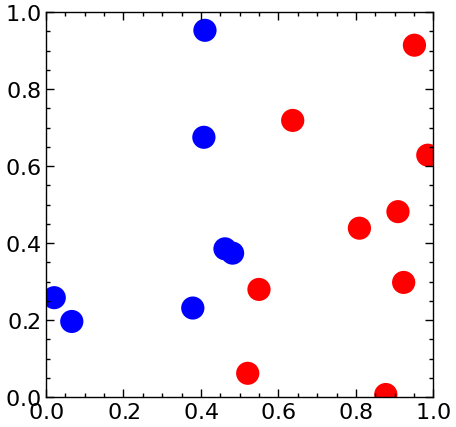

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

FileNotFoundError: [WinError 2] The system cannot find the file specified

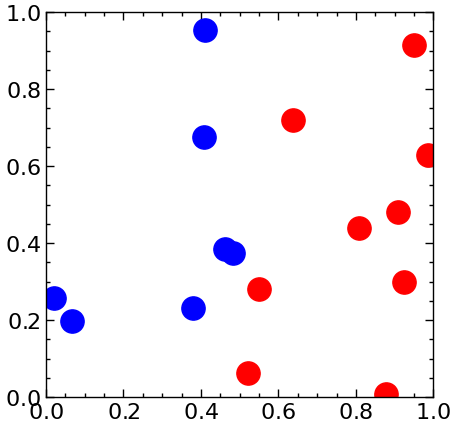

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

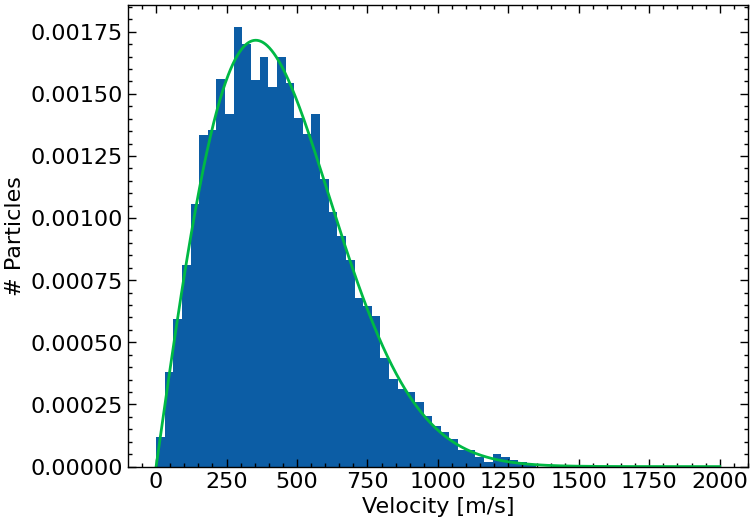

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)